In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from darts import TimeSeries
from darts.utils.utils import generate_index

In [3]:
import streamlit as st
from notionhelper import NotionHelper


In [4]:
def create_ts_data():
    from notionhelper import NotionHelper
    import streamlit as st
    # Influenza Data from Notion
    nh = NotionHelper(st.secrets['NOTION_TOKEN'])
    data_id = st.secrets['DATA_ID']
    inf = nh.get_data_source_pages_as_dataframe(data_id)
    
    inf.drop(columns=['Name','notion_page_id'], inplace=True)
    inf.columns = ['inf', 'week']

    inf['week'] = pd.to_datetime(inf['week'], format='mixed', yearfirst=True)
    inf.sort_values(by='week', inplace=True)
    inf.dropna(inplace=True)
    
    # Filtered_df (current FY's appointments / h_data = historic data uploaded.)
    filtered_df = pd.read_csv('/Users/janduplessis/Downloads/access_tracker_filtered_data-5.csv')
    h_data = pd.read_csv('/Users/janduplessis/Library/CloudStorage/OneDrive-NHS/python-data/ACCESS BI/FILTERED_TRAIN_SET.csv')
    
    filtered_df['appointment_date'] = pd.to_datetime(filtered_df['appointment_date'], format='%Y-%m-%d')
    h_data['appointment_date'] = pd.to_datetime(h_data['appointment_date'], format='%d-%b-%y')
    
    filtered_df.sort_values(by='appointment_date', inplace=True)
    h_data.sort_values(by='appointment_date', inplace=True)
    
    to_date = filtered_df['appointment_date'].max()
    join_date = pd.Timestamp('2025-04-01')
    from_date = h_data['appointment_date'].min()
    
    filtered_df_new = filtered_df[filtered_df['appointment_date'] >= join_date].copy()
    h_data_new = h_data[h_data['appointment_date'] < join_date].copy()
    
    full_train_apps = pd.concat([h_data_new, filtered_df_new], axis=0)
    full_train = full_train_apps.resample('W', on='appointment_date').size().reset_index(name='apps')
    full_train.columns = ['week', 'apps']
    
    combined = inf.merge(full_train, on='week', how='left')
    combined.dropna(inplace=True)
    
    combined_ts = TimeSeries.from_dataframe(combined, time_col='week', value_cols=['apps', 'inf'], freq='W')

    
    return combined_ts

In [5]:
combined = create_ts_data()

<Axes: xlabel='week'>

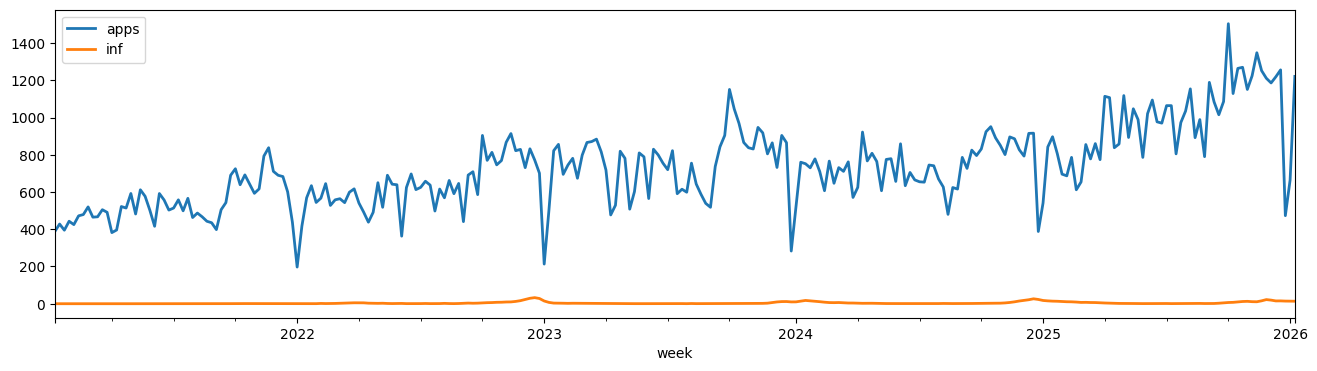

In [6]:
combined.plot(figsize=(16,4))

## Training NBEats Model

In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import MissingValuesFiller, Scaler
from darts.datasets import EnergyDataset
from darts.metrics import r2_score
from darts.models import NBEATSModel
from darts.utils.callbacks import TFMProgressBar
from darts.utils.model_selection import train_test_split

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

In [ ]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(16, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(f"R2: {r2_score(ts_transformed.univariate_component(0), pred_series)}")
    plt.legend()

In [ ]:
end_date = combined_ts.end_time()

In [ ]:
scaler = Scaler()

train, val = train_test_split(combined, test_size=64)

train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
series_scaled = scaler.transform(combined_ts)

train_scaled.plot(label="training")
val_scaled.plot(label="val")
plt.title("Appointments + Influenza Index")

### Generic architecture of N-BEATS

In [ ]:
model_name = "nbeats_run"
model_nbeats = NBEATSModel(
    input_chunk_length=52,
    output_chunk_length=6,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    random_state=42,
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    **generate_torch_kwargs(),
)

In [ ]:
model_nbeats.fit(train_scaled, val_series=val_scaled)

In [ ]:
model_nbeats = NBEATSModel.load_from_checkpoint(model_name=model_name, best=True)

In [ ]:
pred_series = model_nbeats.historical_forecasts(
    series_scaled,
    start=val.start_time(),
    forecast_horizon=6,
    stride=6,
    last_points_only=False,
    retrain=False,
    verbose=True,
)
pred_series = concatenate(pred_series)

In [ ]:
display_forecast(
    pred_series,
    series_scaled,
    "7 day",
    start_date=val.start_time(),
)

### Interpretable model
N-BEATS offers an interpretable architecture consisting of two stacks: A trend stack and a seasonality stack. The architecture is designed so that:

- The trend component is removed from the input before it is fed into the seasonality stack
- The partial forecasts of trend and seasonality are available as separate interpretable outputs

In [ ]:
model_name = "nbeats_interpretable_run"
model_nbeats = NBEATSModel(
    input_chunk_length=26,
    output_chunk_length=6,
    generic_architecture=False,
    num_blocks=3,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    random_state=42,
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    **generate_torch_kwargs(),
)

In [ ]:
model_nbeats.fit(series=train_scaled, val_series=val_scaled)

In [ ]:
model_nbeats = NBEATSModel.load_from_checkpoint(model_name=model_name, best=True)

In [ ]:
pred_series = model_nbeats.historical_forecasts(
    series_scaled,
    start=val_scaled.start_time(),
    forecast_horizon=6,
    stride=6,
    last_points_only=False,
    retrain=False,
    verbose=True,
)
pred_series = concatenate(pred_series)

In [ ]:
display_forecast(
    pred_series, series_scaled, "7 day", start_date=val_scaled.start_time()
)

In [ ]:
for i in range(20):
    print(f"RUN: {i}")
    from darts.models import NBEATSModel
    from darts.metrics import smape
    import numpy as np
    
    # 1. Define a WIDER parameter grid
    # Random search is most effective when you give it many options to explore.
    parameters = {
        "input_chunk_length": [26, 52, 64],
        "output_chunk_length": [6, 12],
        "generic_architecture": [False],
        "num_blocks": [1, 2, 3, 5],
        "num_layers": [2, 4, 8],
        "layer_widths": [512, 1024],
        "n_epochs": [100],
        "batch_size": [32, 64, 128, 256, 512, 800],
        "random_state": [42],
        "force_reset": [True],
        # Wrap torch kwargs in lists as well
        **{k: [v] for k, v in generate_torch_kwargs().items()} 
    }
    
    # 2. Execute Gridsearch with Random Sampling
    # Total grid size here is 4 * 4 * 3 * 4 * 4 = 768 combinations.
    # We will only test 20 of them randomly.
    best_model, best_params, best_score = NBEATSModel.gridsearch(
        parameters=parameters,
        series=train_scaled,
        val_series=val_scaled,
        metric=smape,
        n_random_samples=20,  # <--- This activates Random Search (tries 20 random combos)
        random_state=42,       # Fix the seed so your "random" search is reproducible
        n_jobs=1,              # Recommended for N-BEATS/GPU to avoid OOM errors
        verbose=True
    )
    
    print(f"Best Score (MAPE): {best_score}")
    print(f"Best Parameters: {best_params}")

In [ ]:
from darts.models import NBEATSModel
from darts.metrics import smape

# 1. Define the parameter grid
# Every value must be a list. 
# You can add multiple values to the parameters you want to tune.
parameters = {
    "input_chunk_length": [26, 52, 64],
    "output_chunk_length": [6, 12],
    "generic_architecture": [False, True],
    "num_blocks": [2, 3, 4],           # Example: Tuning the number of blocks
    "num_layers": [4],
    "layer_widths": [256, 512],        # Example: Tuning the width
    "n_epochs": [50],
    "nr_epochs_val_period": [1],
    "batch_size": [800],
    "random_state": [42],
    "force_reset": [True],
    "save_checkpoints": [True],
    # Include your torch kwargs here (e.g., pl_trainer_kwargs)
    **{k: [v] for k, v in generate_torch_kwargs().items()} 
}

# 2. Run the gridsearch
best_model, best_params, best_score = NBEATSModel.gridsearch(
    parameters=parameters,
    series=train_scaled,            # The series to train on
    val_series=val_scaled,          # Split Mode: Evaluate on this validation set
    metric=smape,                    # Optimization metric
    n_jobs=-1,                      # -1 uses all CPU cores
    verbose=False
)

print(f"Best parameters: {best_params}")
print(f"Best MAPE: {best_score}")

Best Score (MAPE): 38.81409970872905
Best Parameters: {'input_chunk_length': 26, 'output_chunk_length': 6, 'generic_architecture': False, 'num_blocks': 2, 'num_layers': 4, 'layer_widths': 512, 'n_epochs': 100, 'batch_size': 128, 'random_state': 42, 'force_reset': True, 'pl_trainer_kwargs': {'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x14ee83070>]}}